In [1]:
import numpy as np
import os,sys


sys.path.append('../../../Env')
sys.path.append('../../../Imaging')
sys.path.append('../../../../RL_lib/Agents/PPO')
sys.path.append('../../../../RL_lib/Utils')
%load_ext autoreload
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
import os
print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/briangaudet/Study/Subjects/MachineLearning/Projects/RL_repo/Exo_intercept/Experiments/EKV/Test_PN


In [2]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

# Optimize Policy

Quaternion_attitude
Euler321 Attitude
C_cb: 
[[ 6.123234e-17  0.000000e+00 -1.000000e+00]
 [ 0.000000e+00  1.000000e+00  0.000000e+00]
 [ 1.000000e+00  0.000000e+00  6.123234e-17]]
[1.000000e+00 0.000000e+00 6.123234e-17]
using max  pooling
Angle sensor:
	Output State type:  <function Angle_sensor.optflow_state at 0x14c8f2d08>
	Offset Init type:  <function Angle_sensor.offset_init1 at 0x14c8f2950>
	Fixed Offset:  None
3dof dynamics model
3-dof Actuator Model:  49.050000000000004
Inertia Tensor:  [[333.33333333   0.           0.        ]
 [  0.         333.33333333   0.        ]
 [  0.           0.         333.33333333]]
Target Model: 
 - foo:  0.0
6dof dynamics model
thruster model:  [4905. 4905. 4905. 4905.]
Rotational Velocity Constraint
Attitude Constraint
Inertia Tensor:  [[1.04166667 0.         0.        ]
 [0.         7.29166667 0.        ]
 [0.         0.         7.29166667]]
Missile Model: 
 - foo:  0.0
Reward_terminal


<IPython.core.display.Javascript object>


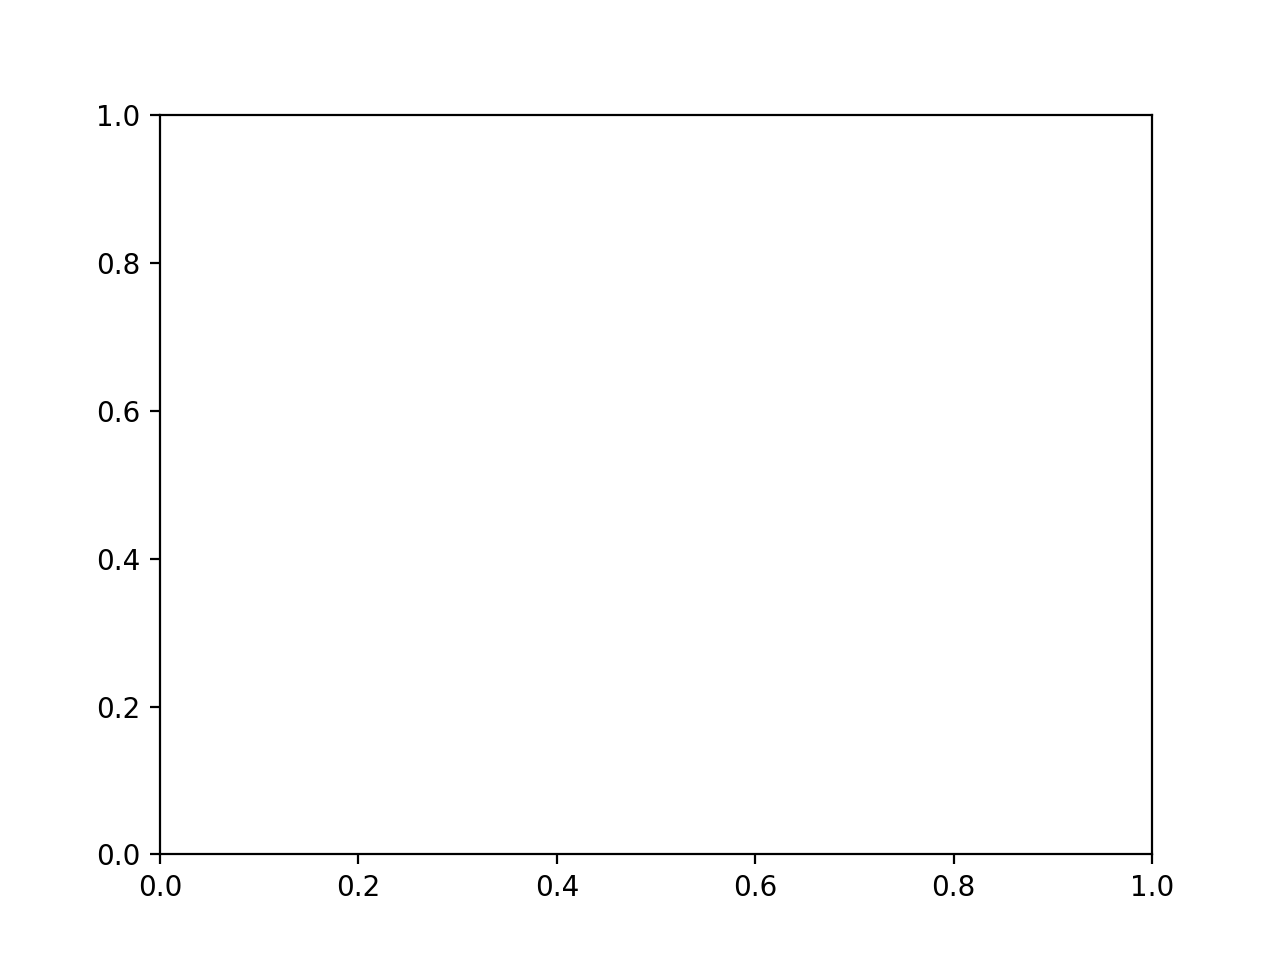

<IPython.core.display.Javascript object>


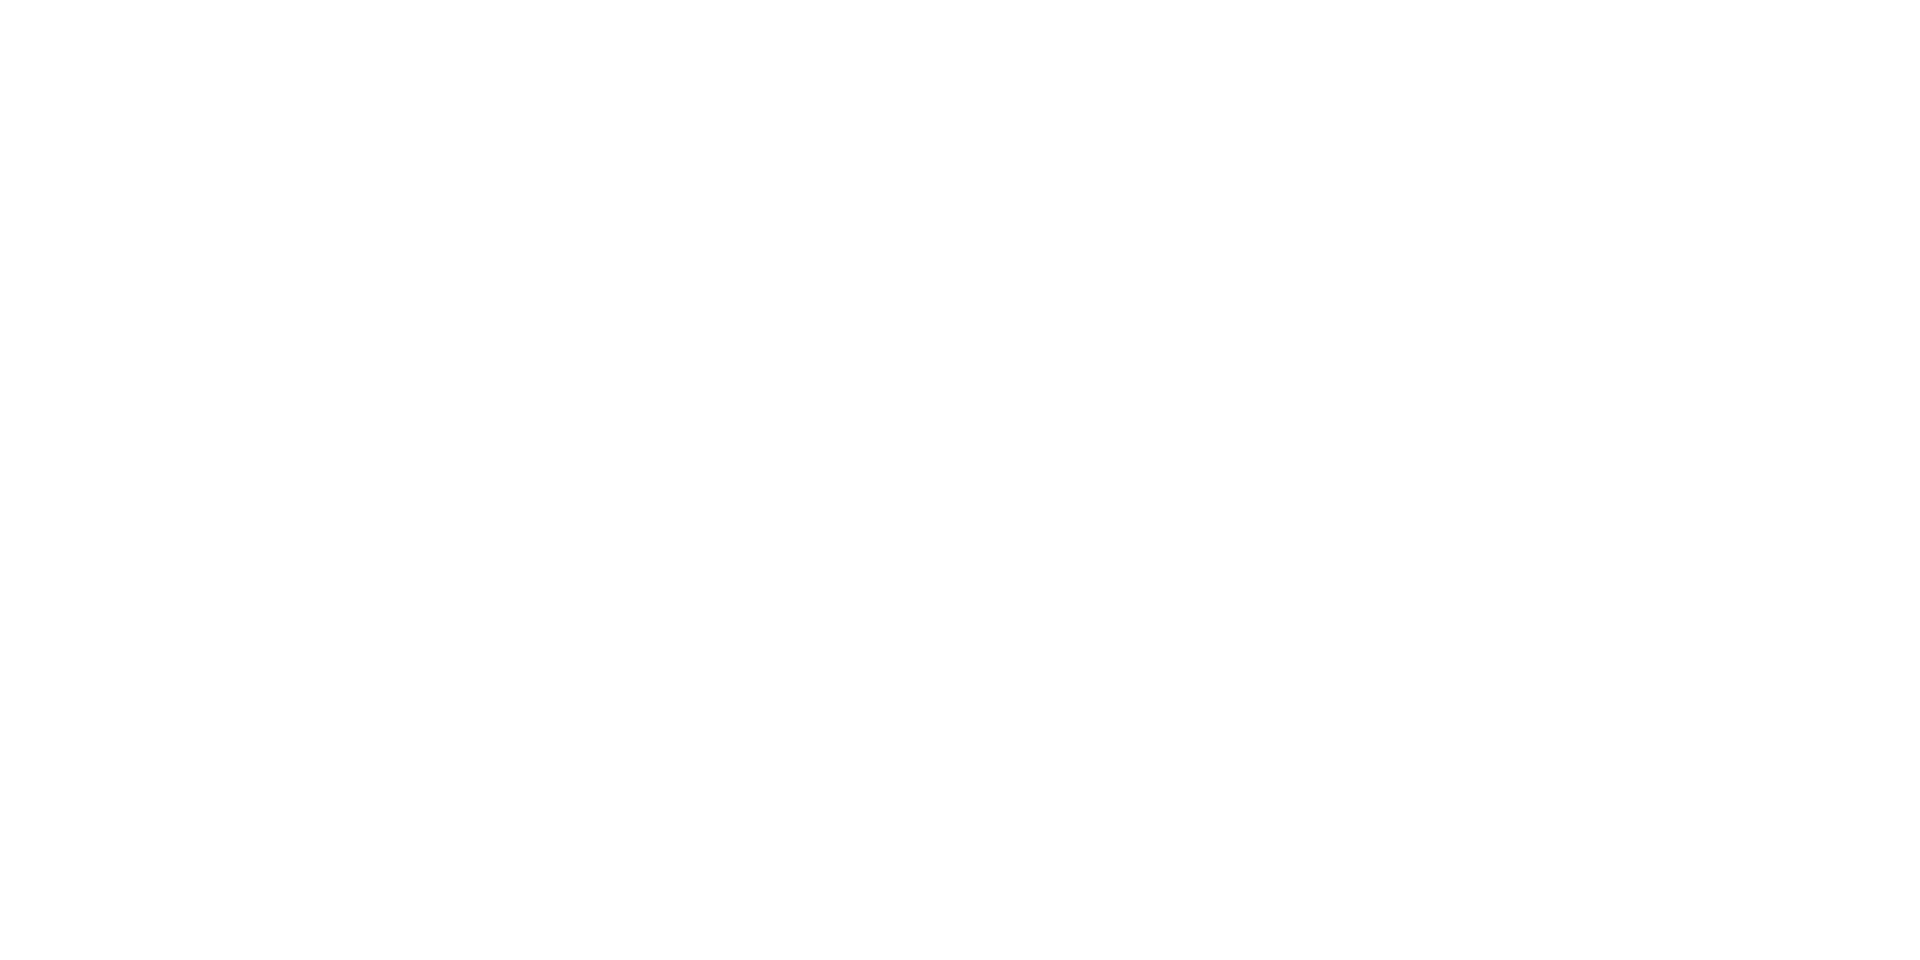

<IPython.core.display.Javascript object>


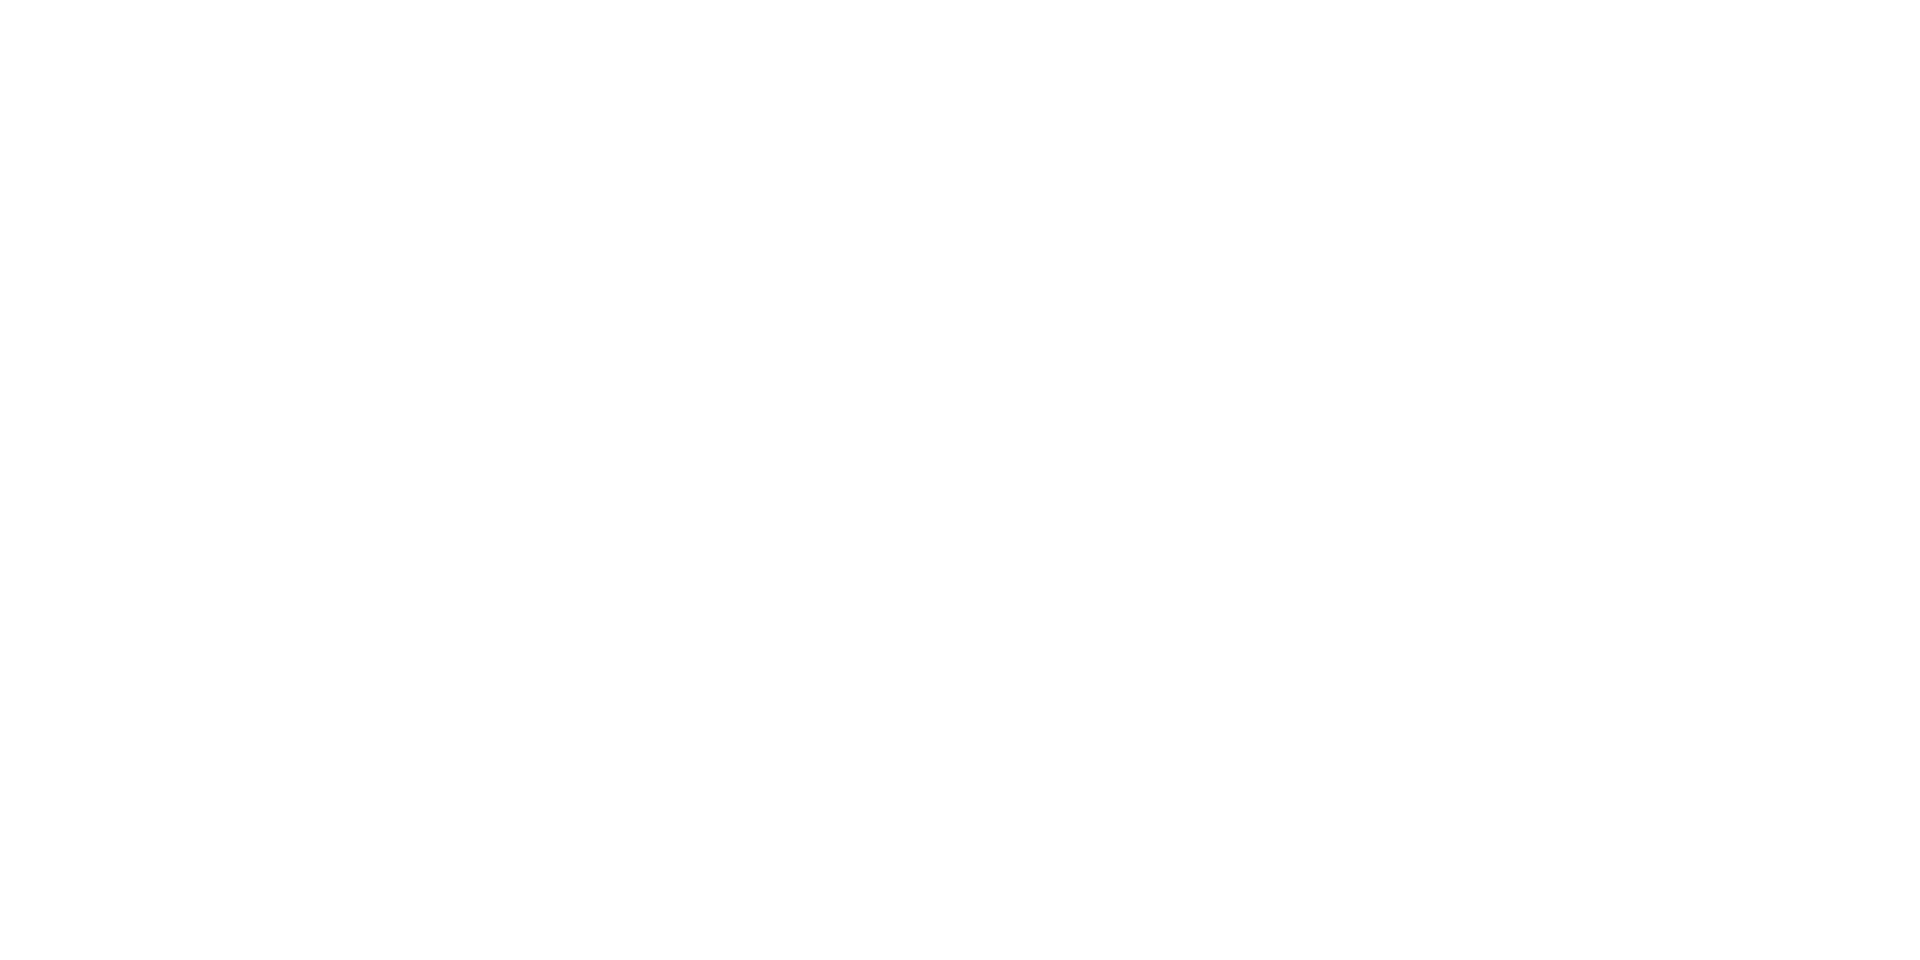

<IPython.core.display.Javascript object>


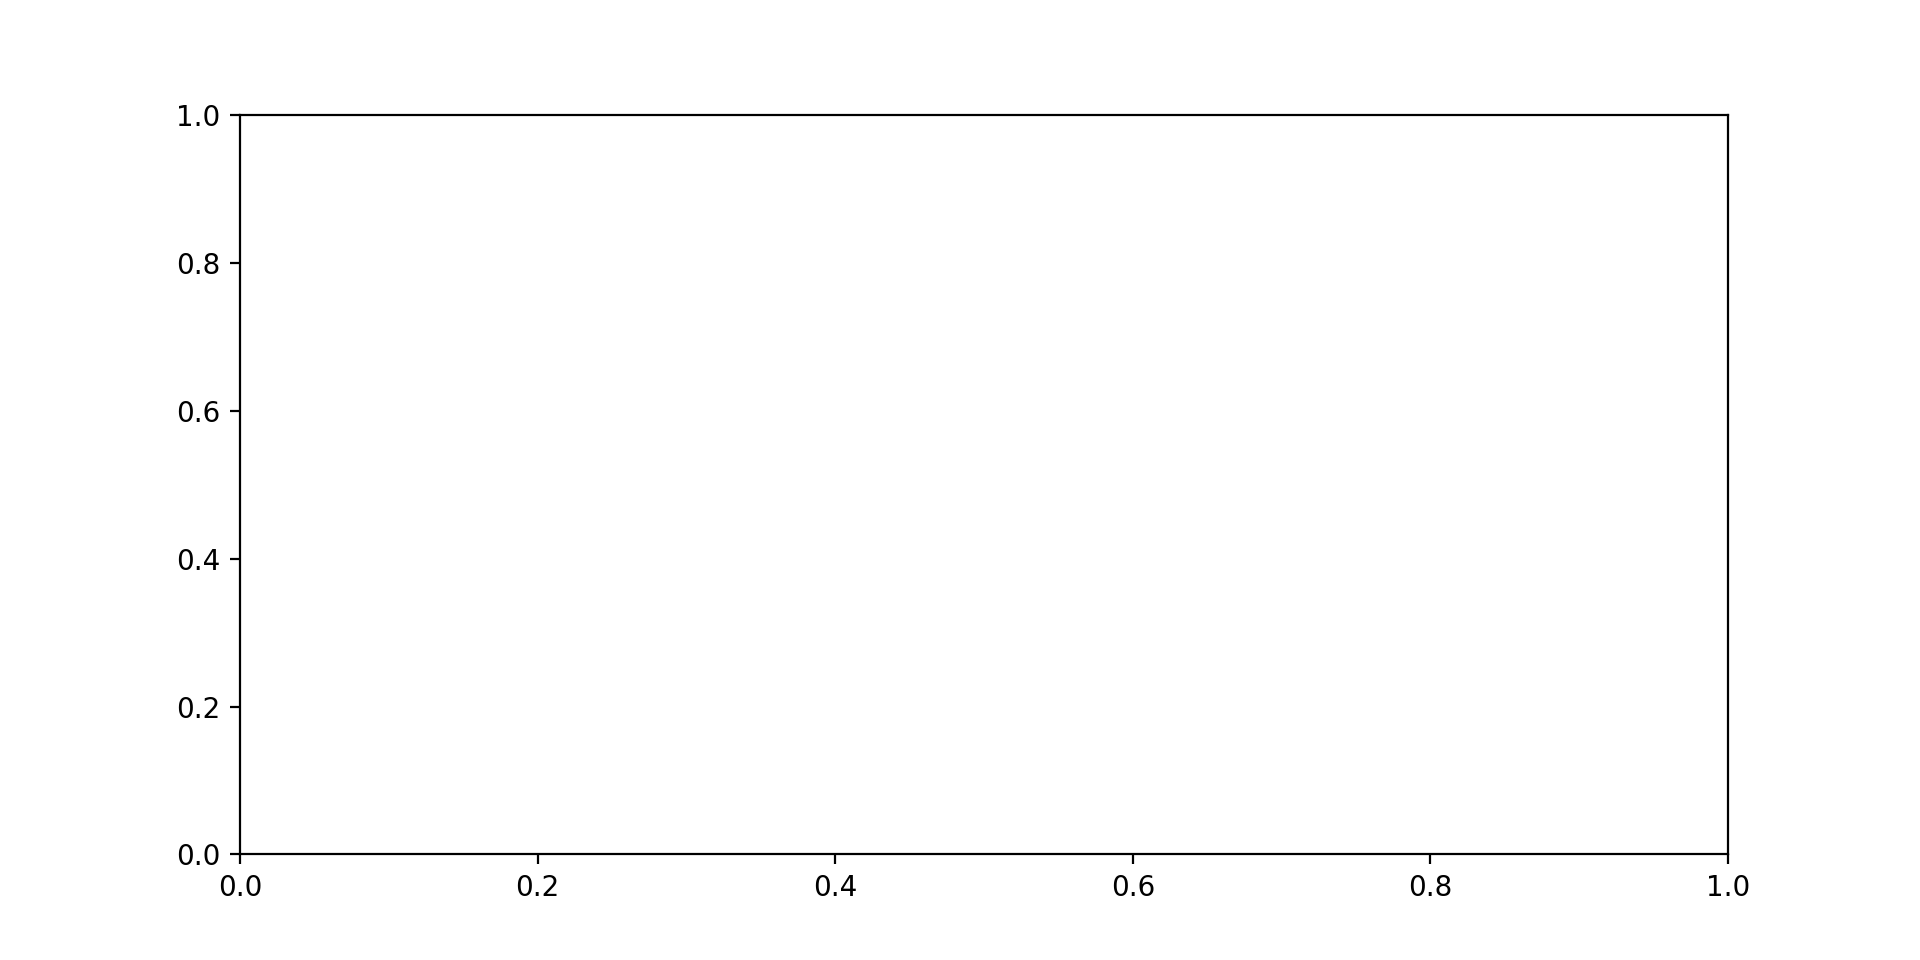

Missile env fixed (h= 0.02
Value Funtion
	xn_init: layer  Linear(in_features=19, out_features=190, bias=True)
	xn_init: layer  GRUCell(190, 30)
	xn_init: layer  Linear(in_features=30, out_features=5, bias=True)
	xn_init: layer  Linear(in_features=5, out_features=1, bias=True)
Value Function: recurrent steps > 1, disabling shuffle and batching
	Clip Range:         0.5
	Shuffle :           False
	Batch Size :        9999999
	Max Grad Norm:      30
	Recurrent Steps:    200
	Rollout Limit:      1
Agent


In [10]:
from env import Env
import env_utils as envu
from reward_sensor_gaussian_of import Reward

import attitude_utils as attu

from missile import Missile
from target import Target

from missile_icgen import Missile_icgen
from target_icgen import Target_icgen

from dynamics_model_3dof import Dynamics_model_3dof as Target_dynamics_model
from dynamics_model_6dof import Dynamics_model_6dof as Missile_dynamics_model

from bangbang_policy_ra import BangBang_policy as Target_policy

from no_att_constraint import No_att_constraint
from no_w_constraint import No_w_constraint

######### RL vs PN ###########

is_RL = False

########## RL ###########

import rl_utils
from arch_policy_vf import Arch
import policy_nets as policy_nets
import valfunc_nets as vf_nets
from agent import Agent
from value_function import Value_function

if is_RL:
    from policy import Policy
    from softmax_pd import Softmax_pd as PD
else:
    from zem_policy import ZEM_policy as Policy
    
######### Actuator Models #########

from actuator_model_ekv import Actuator_model_ekv as Missile_actuator_model 
from actuator_model_3dof import Actuator_model_3dof as Target_actuator_model

######## Sensor ##############

from angle_sensor import Angle_sensor
from eo_model import EO_model
import optics_utils as optu

ap = attu.Quaternion_attitude()

offset=np.asarray([0,0])
C_cb = optu.rotate_optical_axis(0.0, np.pi/2, 0.0)
r_cb = np.asarray([0,0,0])
fov=np.pi-np.pi/8
cm = EO_model(attitude_parameterization=ap, C_cb=C_cb, r_cb=r_cb, 
                   fov=fov, debug=False, p_x=96,p_y=96)
sensor = Angle_sensor(cm, attitude_parameterization=ap,  use_range=True, ignore_fov_vio=not is_RL,
                      use_ideal_offset=False,
                      pool_type='max', state_type=Angle_sensor.optflow_state, optflow_scale=0.1)


########## Target ############

target_voffset = 10
target_max_acc = 5*9.81
target_max_acc_range = (target_max_acc, target_max_acc)
target_dynamics_model = Target_dynamics_model(h=0.02,M=1e3)
target_actuator_model = Target_actuator_model(max_acc=target_max_acc)
target_policy = Target_policy(3,max_acc_range=target_max_acc_range,tf=80)
target = Target(target_policy, target_actuator_model, target_dynamics_model, attitude_parameterization=ap)

target_icgen = Target_icgen(attitude_parameterization=ap,
                            min_init_position=(0.0, 0.0, 50000.),
                            max_init_position=(0.0, 0.0, 50000.),
                            v_mag=(4000., 4000.),
                            v_theta=(envu.deg2rad(90-target_voffset), envu.deg2rad(90+target_voffset)),
                            v_phi=(envu.deg2rad(-target_voffset), envu.deg2rad(target_voffset)))

########## Missile  #############

missile_roffset = 10
missile_mass = 50
missile_max_thrust =  10*9.81*missile_mass

missile_dynamics_model = Missile_dynamics_model(h=0.02,M=1e3)

missile_actuator_model = Missile_actuator_model(max_thrust=missile_max_thrust,pulsed=True)
missile = Missile(target, missile_actuator_model, missile_dynamics_model, sensor=sensor, 
                  attitude_parameterization=ap,
                  w_constraint=No_w_constraint(), att_constraint=No_att_constraint(ap),
                 align_cv=False, debug_cv=False, perturb_pn_velocity=True)
if not is_RL:
    missile.get_state_agent = missile.get_state_agent_PN_att
    
missile_icgen = Missile_icgen(attitude_parameterization=ap,
                           position_r=(50000.,55000.),
                           position_theta=(envu.deg2rad(90-missile_roffset),envu.deg2rad(90+missile_roffset)),
                           position_phi=(envu.deg2rad(-missile_roffset),envu.deg2rad(missile_roffset)),
                           mag_v=(3000,3000),
                           heading_error=(envu.deg2rad(0),envu.deg2rad(5)),
                           attitude_error=(0.0,0.0),
                           debug=False)


reward_object = Reward(debug=False, hit_coeff=10., tracking_coeff=1., tracking_sigma=0.10, optflow_sigma=0.004, 
                       fuel_coeff=0.0, fov_coeff=-0., hit_rlimit=0.5)

logger = rl_utils.Logger()

env = Env(missile, target, missile_icgen, target_icgen,  logger, 
          precision_range=1000., precision_scale=300, terminate_on_vc=not is_RL,
          reward_object=reward_object, use_offset=False, debug_steps=True,
          tf_limit=50.0,print_every=10,nav_period=0.10)

                

##########################################
recurrent_steps = 200
if is_RL:
    obs_dim = 4
    action_dim = 4
    actions_per_dim = 2
    logit_dim = action_dim * actions_per_dim
    policy = Policy(policy_nets.GRU1(obs_dim, logit_dim, recurrent_steps=recurrent_steps), 
                PD(action_dim, actions_per_dim),
                shuffle=False,
                kl_targ=0.001,epochs=20, beta=0.1, servo_kl=True, max_grad_norm=30, scale_vector_obs=True,
                init_func=rl_utils.xn_init)
else:
    policy = Policy(ap=ap, N=3, max_acc=missile_max_thrust / missile_mass)
    obs_dim = 19
    act_dim = 4
    
arch = Arch()

value_function = Value_function(vf_nets.GRU1(obs_dim, recurrent_steps=recurrent_steps), scale_obs=True,
                                shuffle=False, batch_size=9999999, max_grad_norm=30, 
                                verbose=False)

agent = Agent(arch, policy, value_function, None, env, logger,
              policy_episodes=30, policy_steps=3000, gamma1=0.90, gamma2=0.995, 
              recurrent_steps=recurrent_steps, monitor=env.rl_stats)

if is_RL:
    agent.train(300000)

# Test Policy 


In [11]:

env.test_policy_batch(agent,10,print_every=10,test_mode=True)

worked 1
Dynamics: Max Disturbance (m/s^2):  [1.41157302e-12 9.37584890e-14 1.23585922e-12] 1.8784773219597663e-12
Dynamics: Max Disturbance (m/s^2):  [0.0000e+00 0.0000e+00 2.6696e-12] 2.6695999999999994e-12

Cumulative Stats (mean,std,max,argmax)
thrust   |3550.60 |2781.92 |  0.00 |6936.72 |     1

Final Stats (mean,std,min,max)
hit_reward |     6.0 |     4.9 |     0.0 |    10.0
hit_100cm |    0.80 |    0.40 |    0.00 |    1.00
hit_50cm |    0.60 |    0.49 |    0.00 |    1.00
norm_vf  |6835.801 | 117.995 |6616.028 |6992.760
norm_rf  |     0.5 |     0.3 |     0.1 |     1.2
position | 30535.3  -544.4 51499.7 |  1048.0  2029.4  3072.1 | 28666.9 -3840.8 46108.5 | 31777.1  3446.6 55393.4
velocity |-2799.511  85.415  17.130 | 116.067 827.731 725.524 |-2947.395-1133.161-1585.084 |-2569.1191182.0271071.832
fuel     | 15.60 |  2.47 | 11.19 | 19.66
attitude_321 |   0.622  -0.023   0.190 |   2.806   0.215   1.304 |  -2.903  -0.394  -1.929 |   3.092   0.424   2.914
w        |   0.000   0.000   0

<IPython.core.display.Javascript object>


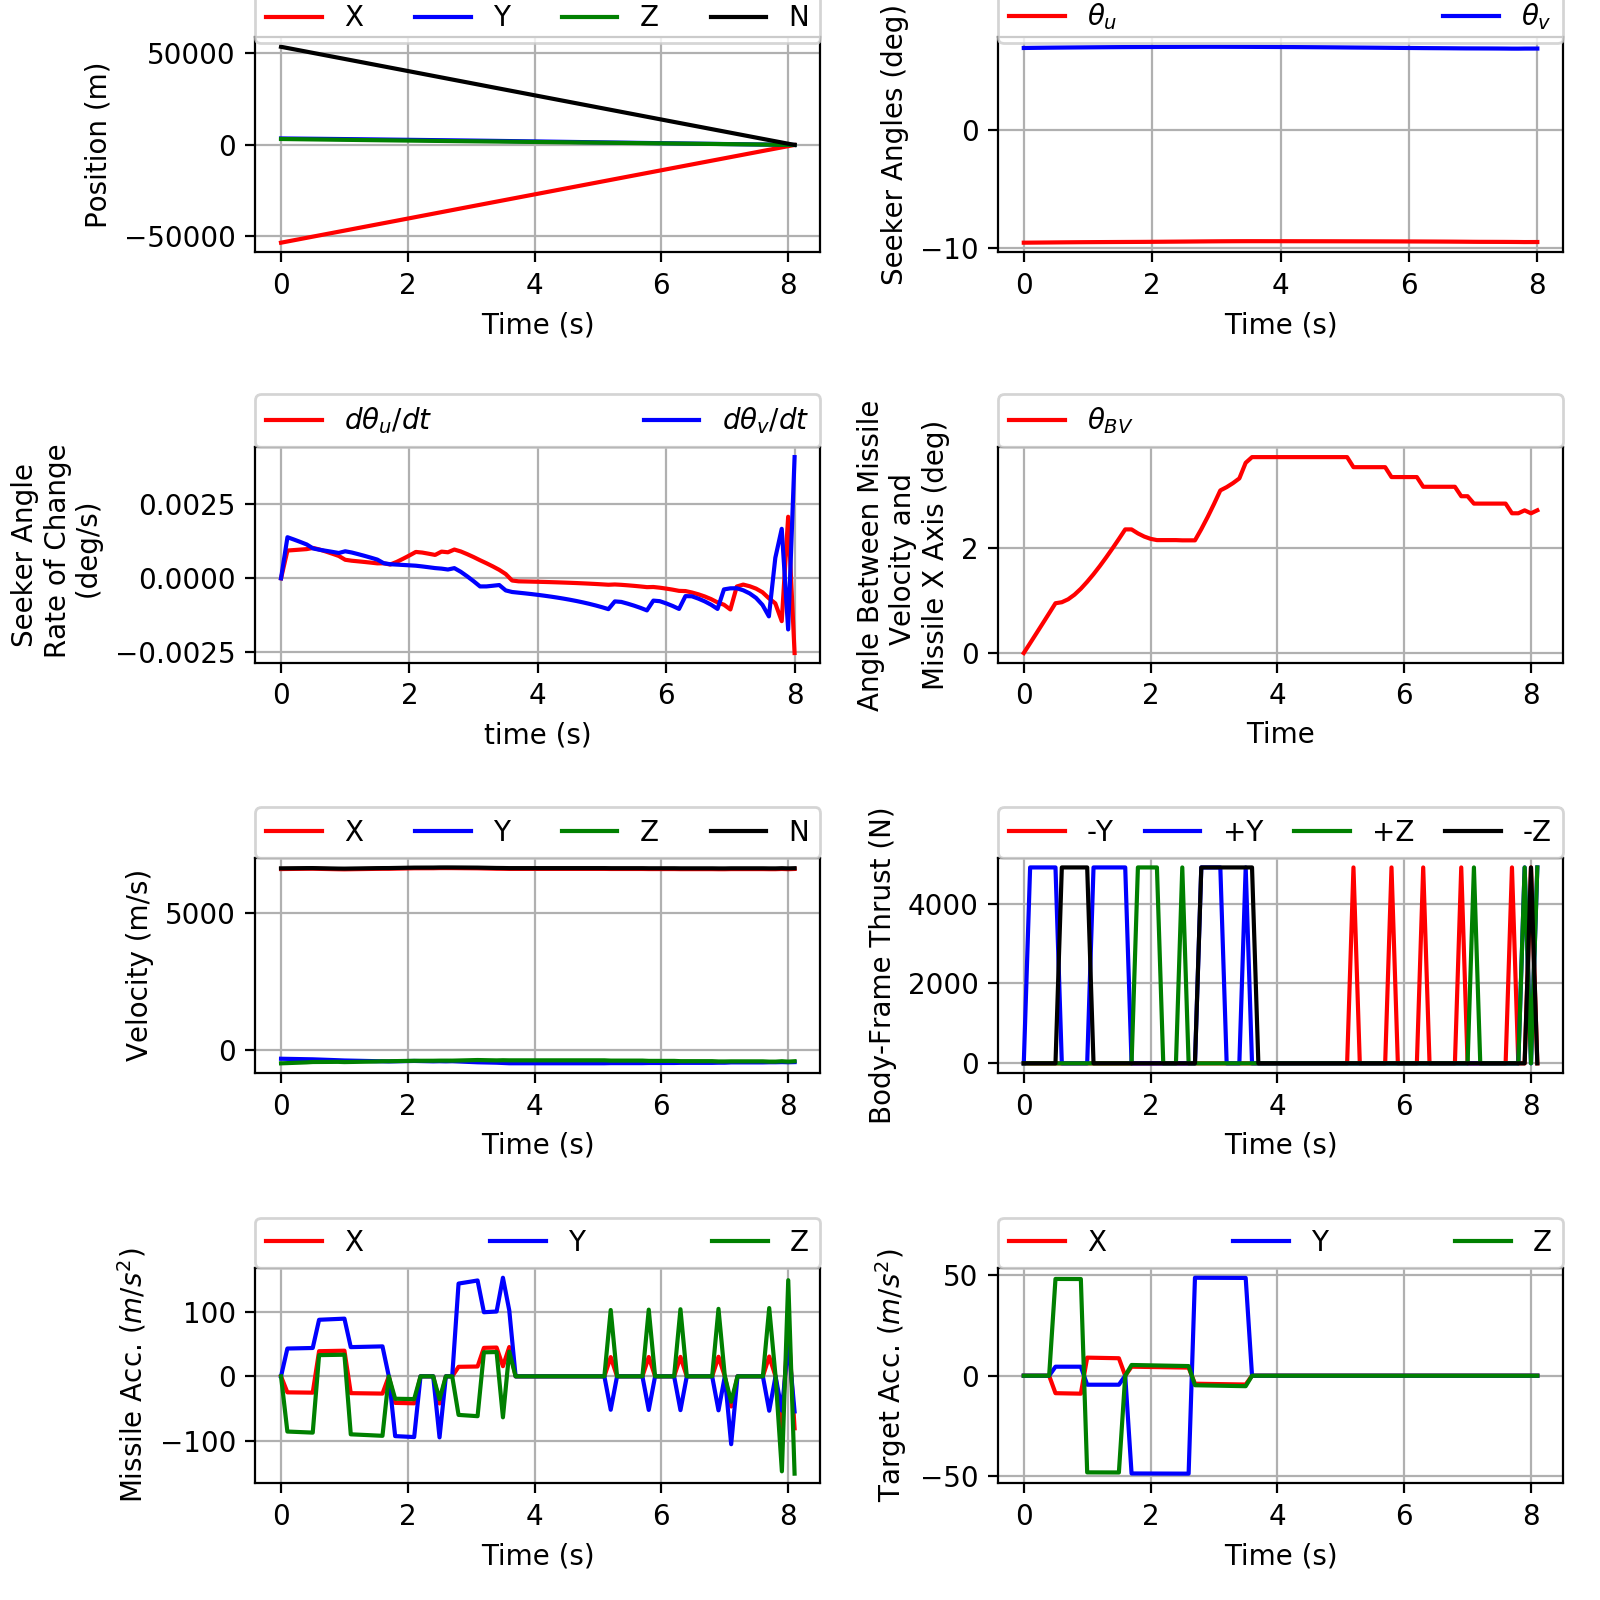

(82, 4)


In [12]:
from render_traj_paper2 import render_traj
render_traj(missile.trajectory_list[0])

In [13]:
traj = missile.trajectory_list[0]
np.save('zem_traj_new',traj)